# Implementation and evaluation of K-nearest neighbors (KNN) algorithm for handwritten digit recognition.
### Nina Gutzeit, Maximimilian Hingerl, Emma Kray, Johannes Müller
### July 2021

## Introduction
The process of converting information, including handwritten documents, images, and sound, into a digital format is known as digitization. The digital format is then readable to a computer.  Digitization is important because it allows us to process, store, and share data. The revolutionary idea behind digitization is that theoretically, the information can constantly be updated and revised without generation loss. One of the biggest issues with digitization is that the data is not as stable as the analog data. The stability of the data encompasses a variety of issues, including resource allocation, policy, and technologies. Resource allocation is a big issue with digitization because large segments of land are needed to build cloud storage facilities. The facilities also have a substantial environmental impact on the neighboring communities and the world at large.  For one, the facilities consume a massive amount of the world’s total electricity. Greenpeace estimates that by 2025, the technology sector will use 20% of all electricity.   2% of all global carbon emissions is also linked with cloud computing and digitization.  Also, nearly 460 liters of water are needed every day to cool the cloud storage facilities.
The policy issues include personal rights policies, preservation policies, and cybersecurity. The last issue is creating technologies that can effectively and accurately transform information into a uniform digital format.

Digitization can be reduced to a few simple steps. The first step is creating a data set with the information. Then, standardizing the dataset and reducing the data, using, for example, principal component analysis. The most important step is using a classification algorithm like K-nearest Neighbors (KNN). KNN calculates the distance between the training and test data point, compares the distance to the k nearest neighbors’ labels, decides which label appears the most frequently under k nearest neighbors, and assigns a predicted label accordingly.


In [131]:
# imports
%load_ext autoreload
%autoreload 2
import itertools
import multiprocessing
from IPython.display import Image
import numpy as np
import functions.Standardize as stan
import functions.visualize_stan as vis_stan
import functions.PCA as pca
import functions.visualize_pca as vis_pca
import functions.KNN_predict as knn
from functions.Load_data import load_the_pickle
from functions.visualize_stan import sample_digits
from scipy.spatial import KDTree
import functions.visualize_knn as vis_knn
from functions.Phone_numbers import form_filled_in
from functions.Phone_numbers import call_me_maybe
from functions.Phone_numbers import show_phone_numbers
from functions.Data_cleaning import any_na
from functions.Data_cleaning import rm_range

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_labels, train_values = load_the_pickle('data/train_points.p')
test_labels, test_values = load_the_pickle('data/test_points.p')

## The data set
The data set consists of a training set of 60000 images and a test test with 10000 images. Each image is 28*28 pixels in size and the handwritten digits have been cropped to the center of the image. The data format is a csv file in which each row has the intensity values of the pixels of one image. The first column has the digit labels.

Below is a random sample of 25 images:

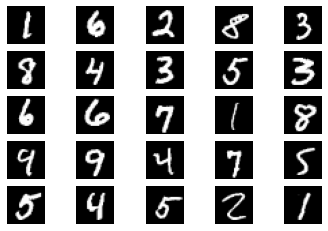

In [2]:
# loading a selection of images
sample_digits()
print("Fig. 1: sample digits")

## Data cleaning
The first step when dealing with such a data set is to check for errors or irregularities. Unexpected values such as NA values or outliers with intensity values outside of the range(0, 256) need to be dealt with. Possible solutions are removing the affected images or imputation of the individual values.


In [57]:
# Checking Training data for missing values:
any_na(train_values)
# Checking Test data for missing values:
any_na(test_values)

There are no missing values in this data.
There are no missing values in this data.


In [3]:
# Checking data for range
rm_range(train_values)
rm_range(train_labels, upper=10)
rm_range(test_values)
rm_range(test_labels, upper=10)

No values out of range.
No values out of range.
No values out of range.
No values out of range.


There are no irregularities of these kinds in the data set.

Other types of unusual data could include duplicate images. This can interfere with the knn algorithm and therefore need to be removed:

In [59]:
from functions.Data_cleaning import rm_duplicates
rm_duplicates(train_values)
rm_duplicates(test_values)

No Duplicates.
No Duplicates.


Again there are no duplicate errors. The data is cleaned, however errors such as incorrect image labelling and image orientation are not accounted for.

## Standardization and PCA preparation
The images have different brightnesses and therefore need to be standardized. The intensity mean is calculated over every image and subtracted from each pixel. These values are divided by the standard deviation. The resulting images are standardized. Here is how this looks on an example image:

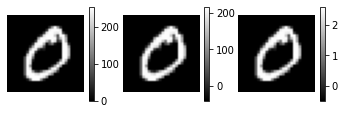

In [60]:
from functions.visualize_stan import compare_stan
compare_stan()
print("Fig. 2: comparison of digits after standardization")

The left image is the original digit image. In the middle is the result of only subtracting the mean and on the right is the fully standardized image. The images look the same because of how plt displays images. This proves that no information is lost. The color bars show how the images differ. The algorithm performs better on the fully standardized images.

The data needs to be prepared for PCA by standardizing it across all images. This is done because it is important that all pixels have the same magnitude/ weight. This is especially important for data with variables that have different units. Here differences in variance can occur between different pixel positions. For example one pixel position could have intensities between 0 and 9 whilst another pixel has values between 100 and 150. This can cause the PCA to 'unjustly' assign more importance to the larger variance. The second pixel will dominate the principle components even if the variance of the first pixel is just as defining.

Here two different operations were performed to prepare the data. The data was centered in a covariance operation or it was Z-transformed in calculating the correlation matrix.

Covariance is calculated by:
$$\text{cov}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \left(X_i - \overline{X}\right)\left(Y_i - \overline{Y}\right)$$

where X and Y are columns of a given matrix, N is the number of columns and cov(x,y) is the resulting entry of the covariance matrix.

The covariance operation includes centering: $ (X_i - \overline{X}) $, where the mean of X is subtracted from each value in the column. The same is true for Z transformation and correlation:

$$ Z: \dfrac{(X_i - \overline{X})} {\sigma _ {i}} , \text{corr}(x,y) = \frac{1}{N - 1} \cdot \sum_{i=1}^{N} \dfrac {\left(X_i - \overline{X}\right)}{\sigma_{x}}\dfrac{\left(Y_i - \overline{Y}\right)}{\sigma_{y}} $$


where ${\sigma_{x}}$ is the standard deviation of the column X. In the dataset a column represents the intensity values of all images at a specific pixel position.

The mean and standard deviation of the training data set are used to prepare the images of digits to be predicted. This is because: (...). One matrix is standardized using the mean and standard deviation of the other matrix containing the training data.

Pixel positions in the training data set where every image has the same intensity value give a standard deviation of 0. Mathematically this leads to undefined values in the correlation matrix which the program returns as 'Nan'. Running the final algorithm over this data with the Nan values leads to a very poor result of less than 10% correct digit predicitions.

However, these variables include no information that distinguishes a "1" from a "2" because the values are the same accross all digits. Therefore instead of replacing 'Nan's with another value, these variables could be removed entirely. The same variables need to be removed in the test images.

In [61]:
train_values = stan.standardize(train_values)
test_values = stan.standardize(test_values)

train_values_centered, train_mean = stan.center(train_values)
test_values_centered, test_mean = stan.center(test_values, y=train_values)


## Principal Component Analysis
### Introduction
After the dataset was split and standardized, Principal Component Analysis (PCA) was applied. PCA is used to reduce the dimensionality of a data set by preserving the variables with the most directional variance. This minimizes the loss of information. PCA can help increase the interpretability of a data set. The principal components are calculated using eigenvalues/eigenvectors, where the eigenvectors are the principal components.

In [62]:
n_pca = 30


train_values_pca, train_evs = pca.pca(train_values_centered, train_mean, num_components=n_pca)
test_values_pca, _ = pca.pca(test_values_centered,test_mean, num_components=n_pca , train_evs=train_evs)

Figure 3 shows the position of each test point in a three dimensional graph. Each digit is colored differently.

c:\users\jojo3\.conda\envs\2021-topic-04-team-02\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning:

invalid value encountered in sqrt



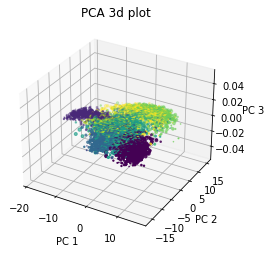

Fig. 3: 3D plot of test values


In [152]:
import importlib
importlib.reload(vis_pca)
#vis_pca.components_3d(test_values_pca, test_labels)
vis_pca.components_3d(test_values_pca, test_labels, "PCA 3d plot")
print("Fig. 3: 3D plot of test values")

When visualizing digits with similar characteristic it is ofter hard to distinguish them. For example, the digits 3 and 6 are not distinguishable from one another, as seen in image....
When visualizing digits, in this example 3 and 6, they aren't distinguishable from another in the first picture.

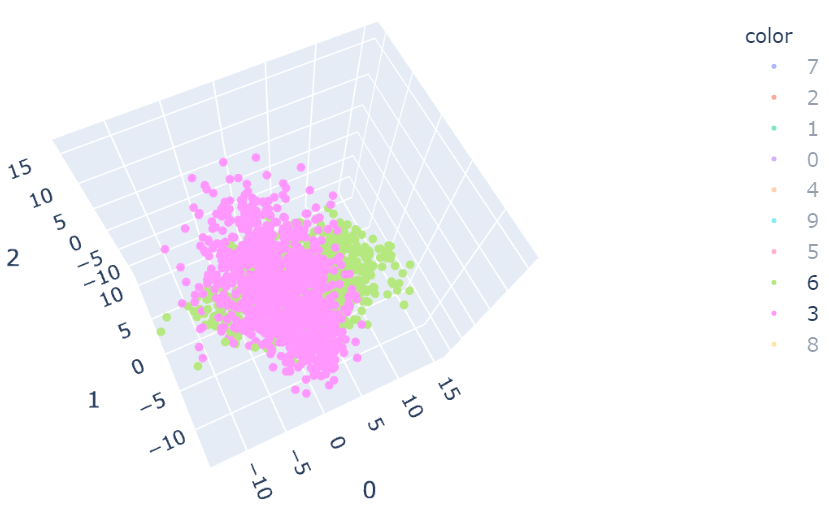

In [122]:
Image("data/3d_plots/pca_before.png")

In the image.... the view on the data set was changed and 3 and 6 can easily be distinguished from another.

In [ ]:
![digits 3 and 6](data/3d_plots/pca_after.png)

The figure 4 and 5 visualize the test values and train values in a two dimensional graph.
In both figures the distribution of the digits is similar, as can be seen when looking at the digits 8, yellow, and 6, green points, which makes them harder to distinguish.


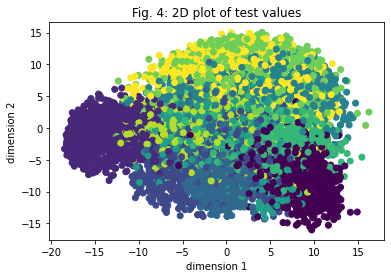

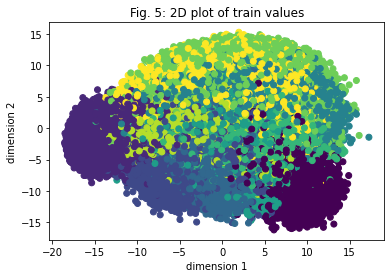

In [176]:
import importlib
importlib.reload(vis_pca)
vis_pca.components_2d(test_values_pca, test_labels, x_label= "dimension 1", y_label= "dimension 2", title="Fig. 4: 2D plot of test values")
vis_pca.components_2d(train_values_pca, train_labels, x_label= "dimension 1", y_label= "dimension 2", title="Fig. 5: 2D plot of train values")


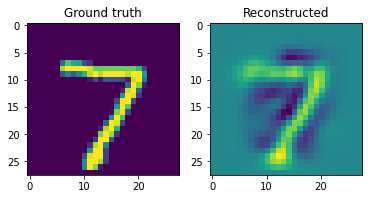

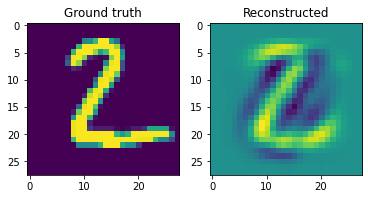

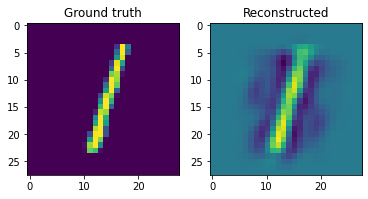

In [173]:
vis_pca.components_reduced(test_values_pca, train_evs, test_values)

Figure 4 and 5 also show that some numbers can be easily distinguished from another, like for example the digit 1.
But there are also many digits that look very much alike. Which is why the PCA is so important.

### mathematical background
Eigenvectors are a set of vectors associated with a linear system of equations, such as a matrix. The idea behind an eigenvector is that given any matrix there is a set of n vectors $v_i$, that when multiplied with A results in a parallel/antiparallel vector to $v_i$. The resulting vectors length is then multiplied with the eigenvalue, which is some constant value. The mathematical definition of an eigenvector $v_i$ can be explained with the following equation:

$Av_i=λ_i v_i$

where A is the matrix and λ is the eigenvalue.

To calculate the eigenvector, first the eigenvalues need to be calculated. The formula

$det⁡(A-λI)=0$

can be used to calculate the eigenvalues. The determinant (det) of the difference between A and λ times I, the identity matrix, can be used to calculate the eigenvalues. The identity matrix consist of ones along the diagonal and zeros everywhere else. The solutions of λ are the corresponding eigenvalues for the matrix.

The last step is then calculating the eigenvectors using the eigenvalues. The formula

$Av_i=λ_i v_i$

is rearranged t

$(A-λ_i)\cdot v_i=0$

which, for example, for 2x2 matrix would looks like this:

\begin{pmatrix}
A-λ_i & A-λ_i\\
A-λ_i & A-λ_i
\end{pmatrix}
\begin{pmatrix}
v_{i,j}\\
v_{i,j}
\end{pmatrix}
= 0


From the resulting polynomial one can determine the eigenvector specific to the eigenvalue. The above calculation must be completed for every eigenvalue λ.


The eigenvectors are ranked based on their influence on the covariance of the data set. The eigenvectors with less significant directional variance are removed. This reduces the overall dimensionality.

## Our code

The variables `eigen_values, eigen_vectors` consist of the calculated eigenvalues and -vectors for the standardized train data set.

```python
sorted_eigenvectors = eigen_vectors[:, sorted_index]
```
The above function sorts all eigenvectors based on greatest impact on variance.

The sorted eigenvectors are then reduced to the optimal number of components. The optimal number of components has the highest accuracy.

The function
```python
eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
```
reduces the number of eigenvectors to the optimal number of principal components.
The attribute `train_evs` usually set to `train_evs=NONE`, which will be used during the iterations of the train set. When calling `PCA_func` on the test set, this attribute is set to `train_evs=train_evs`.
This then fullfiles the `if train_evs is not None` clause. The clause states:

```python
    if train_evs is not None:
        eigenvector_subset = train_evs
    X_reduced = np.dot(X_mean, eigenvector_subset)
    return X_reduced, eigenvector_subset
```

This code segment reduces the number of principal components of each test point to the before calculated subset of the training points.
At the end a matrix reduced to the number of principal components and the eigenvector subset are returned for further analysis.

## The knn algorithm
The next step is implementing the KNN algorithm. In contrast to other classification methods, KNN uses a one-step approach instead of two-steps. The two-step method trains a model using the training data. Then model is then used to predict the class of the test data point.
The one-step approach directly uses the training data to predict the class of the test data. (pg 163 citation am introduction to statistical learning Gareth james). The algorithm calculates the distances between one test data point and all training points, and then sorts the distances by size. The k lowest distance is selected, and the labels of the corresponding training points are analyzed by the voting function. The voting function selects the major vote based on how frequently each unique label occurs in these k nearest neighbor. The returned major vote is the predicted value for the tested data point.
The KNN function needs as an input the training data as an array, a corresponding list of labels, and the preferred distance method, the number k neighbors, and the data point x, which needs to be classified.


In [ ]:


train_values = stan.standardize(train_values)
test_values = stan.standardize(test_values)

k = 5
n_pca = 30
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = pca.pca(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, y=train_values)
test_values_pca, _ = pca.pca(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

### distance methods
The KNN algorithm takes the preferred distance as an input parameter. Two methods for calculating the distances were compared to see which performed better. The two methods were the Euclidean distance and the Manhattan distance.

$d_{Euclidean}(x,y)= \sqrt{\sum^{n}_{i = 1}(x_i-y_i)^2} \\$
$d_{manhatten}(x,y)= \sum^{n}_{i = 1}|x_i-y_i| $

$X_i$ represents the coordinates of training data point and $y_i$ the coordinates of the tested data point.

The KNN algorithm delivers with both distance calculation methods very good results. As seen below, the algorithm performs slightly better when using the Euclidean distance and correctly identifies xx digits more. The amount of time the algorithm needs to run is roughly the same for both methods.

In [ ]:
%%time

hit_euclidean = 0
miss_euclidean = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("euclidean",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_euclidean += 1
    else:
        miss_euclidean += 1

In [ ]:
%%time
hit_manhattan = 0
miss_manhattan = 0
predicted_label = []
for i in range(10000):
    result = knn.knn("manhattan",train_values_pca,train_labels,test_values_pca[i],k)
    predicted_label.append(result)

for sample in range(10000):
    if predicted_label[sample] == test_labels[sample]:
        hit_manhattan += 1
    else:
        miss_manhattan += 1
        

In [ ]:
print("correctly classified vs wrongly classified numbers using  the euclidean distance:",hit_euclidean, "vs", miss_euclidean)
print("correctly classified vs wrongly classified numbers using the manhattan distance:",hit_manhattan, "vs", miss_manhattan)

### ways of implementing knn

#### slow and simple code and the introduction of multiprocessing
The first version of the algorithm, which we used above, is a function which classifies one test data point at a time, each time calculating the 60.000 distance to the training point. The function needs to be run for each tested point which results in 10000 iterations resulting in a run time of over 4 minutes, depending on the used system.
To improve that, python multiprocessing was integrated into the functioning but slow algorithm. Instead of running one process that iterates 10000 times over the knn function, the multiprocessing function gets a range of numbers with which it should run the function and than creates a "pool" of tasks and starts an individual python process for each batch of tasks. That means that based on the system which runs the code, the function creates multiple processes at once and splits the workload onto all processing cores of the computer.
For example on a computer with 4 cores the code can run 4 processes at a time efficently, due to that optimization we could bring down our run time from over 4 minutes to about 2 minutes as you can see below.

In [ ]:
%%time
hit_knn_multiprocessing = 0
miss_knn_multiprocessing = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_multiprocessing += 1
            else:
                miss_knn_multiprocessing +=1
        print("correctly classified vs wrongly classified numbers using multiprocessing",hit_knn_multiprocessing, "vs", miss_knn_multiprocessing)

#### quick and complicated by introducing kd-trees
As we later on need to run the code several hundred times to optimize the number of n principles components and k nearest neighbours, we needed to bring down our run time even more. The most time consuming parts were the calculation of 60000 distances and sorting them by size in each iteration.
One method to circumvent calculating 60.000 distances works by building a kd-tree once and then making a query for each tested point. A kd-tree is a space-partioning data structure used for organizing points. The k dimensions are represented by the n principal components in our case.
The kd-tree is a binary data structure which is constructed by splitting the data set along the median of the first dimension $x_1$ in two groups. These groups are then being splitted again using the the median of the second dimension $x_2$ creating four groups. By continuing this procedure for each dimension $x_n$, a tree-like structure is being generated, which can be saved into an variable. When we now need to search for the k nearest neighbors of our tested data, we can quickly search for the nearest neighbors by going down the tree and comparing the medians of each dimension with the values of our tested data point. (Quelle)
In the end we know in which subgroup of points we need to search for the k nearest neighbors, which reduces the amount of calculated and sorted distances drastically. For building the kd-tree and making querys we used the KDTree and query function from the scipy.spatial package.
The KDTree functions takes a array as an input and the query function needs the data point x, a value for k and the norm for the distance ethod as an input (1 for Manhattan, 2 for euclidean)
By using the kdtree we were able to bring down our processing time to about 24 s while still retainig the same accuracy.


In [ ]:
%%time
tree = KDTree(train_values_pca)

hit_knn_kdtree = 0
miss_knn_kdtree = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_kdtree += 1
            else:
                miss_knn_kdtree +=1
        print("result using a kdtree",hit_knn_kdtree, "vs", miss_knn_kdtree)


### optimal number of k and pcs
In order to improve the accuracy of our algorithm we needed to find the optimal number of k nearest neighbours and n principal components.
We did this by using two for loops to test accuracy using a range of values for k and n and iterating through them. We tested for 5 to 80 principal components and 2 to 12 k neighbours.
The code needed to run for about 7 hours and we saved the result as a list containing the number of correctly classified numbers for each pair of k and n.
To visualize this data we plotted a heatmap an a 3d plot of this data.


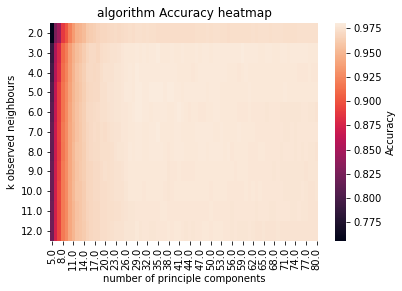

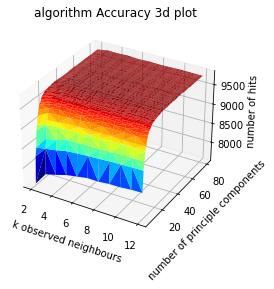

In [117]:
#normal-mnist:
vis_knn.knn_heatmap("data/visualize_knn_mnist.npy",dropped_rows=[],dropped_columns = [],figure_title="algorithm Accuracy heatmap")
vis_knn.knn_3dplot("data/visualize_knn_mnist.npy",figure_title="algorithm Accuracy 3d plot")


As you can see in both plots, the accuracy rises pretty quickly as the number of principle components increases and the number of k observed neighbours seems to be less important.
To better observe the area, where the accuracy quickly rises we plotted the selection of the same data again below.
Additionaly we can search in the saved data behind these plots for the absolute best n and k by using np.argsort.

highest accuracy/number of correctly identified images and the corresponding n and k values: [[  30    5 9803]]


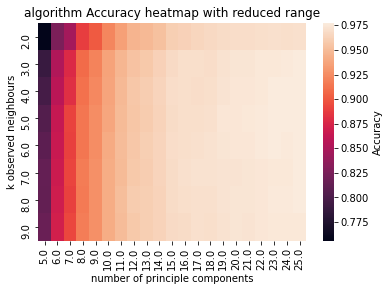

In [115]:
vis_knn.knn_heatmap("data/visualize_knn_mnist.npy", dropped_rows=([i for i in range(10,13)]), dropped_columns = ([i for i in range(26,81)]),figure_title="algorithm Accuracy heatmap with reduced range")

mydata = np.load("data/visualize_knn_mnist.npy")
print("highest accuracy/number of correctly identified images and the corresponding n and k values:",mydata[np.argsort(-mydata[:,2])[:1]])


As shown above we get the highest accuracy for 5 observed neighbours and 30 principle components resulting in 9803 correctly identified numbers.
The question is if that would be the best choice in a practical application, as the run time increases with a higher number of k neighbours an n principal components.
At the same time the accuracy improvement is very low, as you can see in the heatmap above.
To demonstrate this we ran the code again and timed it and compared the results below:

In [ ]:
k = 5
n_pca = 30
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = pca.pca(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, y=train_values)
test_values_pca, _ = pca.pca(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

In [ ]:
%%time
tree = KDTree(train_values_pca)

hit_knn_30_5 = 0
miss_knn_30_5 = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_30_5 += 1
            else:
                miss_knn_30_5 +=1


In [ ]:
k = 3
n_pca = 20
# standardization and PCA:
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = pca.pca(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, y=train_values)
test_values_pca, _ = pca.pca(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

In [ ]:
%%time
tree = KDTree(train_values_pca)

hit_knn_3_20 = 0
miss_knn_3_20 = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.kdtree_knn, zip(test_values_pca[range(10000), :], itertools.repeat(k),itertools.repeat(train_labels), itertools.repeat(tree), itertools.repeat("euclidean")),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_knn_3_20 += 1
            else:
                miss_knn_3_20 +=1


In [ ]:
print("result using k=5 and n=30:",hit_knn_30_5, "vs", miss_knn_30_5)
print("result using k=3 and n=20",hit_knn_3_20, "vs", miss_knn_3_20)

As expected with a lower k and less principle components the code runs much faster while still having a good accuracy.
In this example the "optimal" configuration with a k of 7 und 55 principal components took 22.4 s to run and had an accuracy of 97.65%.
The "time-saving" configuration with a k of 4 and 25 principal components took 7.74 s to run an had an accuray of 97.32%.
So in comparison the code ran about three times faster while only loosing 0.33% of the accuracy.
In an application where pictures need to be in real time or to improve the customer experience for end users it could be viable to sacrifice a bit of the accuracy to reduce the run time.

# Additonal tested stuff

## Weighted knn
The weighted knn algorithm is almost identical to the normal knn algorithm. The normal knn method solely counts the number labels of nearest neighbours and returns the major vote.
This doesn't take into account that closer neighbours might be more reliable in indicating the class of our tested data.
To take this into account we programmed a weighted KNN function based on inverse distance weighting.
For this additionally to the distance a weight is calculated fot the nearest neighbours by using this formula:

$\lambda_i(x,y) = \frac{1}{distance(x,y)^2} $

The weights are then beeing normalized:

$\lambda_{i}^*(x,y) = \frac{1}{\sum_{l=1}^{n}\lambda_l(x,y)} $

We implemented this and optimized the algorithm for the highest accuracy as before.

In [ ]:
weighted_knn_data = np.load("data/visualize_weighted_knn.npy")
print("highest accuracy/number of correctly identified images and the corresponding n and k values:\n",weighted_knn_data[np.argsort(-weighted_knn_data[:,2])[:3]])
vis_knn.knn_heatmap("data/visualize_weighted_knn.npy",dropped_rows=([7, 8, 9, 10, 11, 12]),dropped_columns = ([25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80])figure_title="algorithm Accuracy heatmap with reduced range for weighted KNN")

In [ ]:
%%time
k = 4
n_pca = 34
train_values_centered, train_mean = center(train_values)
train_values_pca, train_evs = pca.pca(train_values_centered, train_mean, num_components = n_pca)

test_values_centered, test_mean = center(test_values, y=train_values)
test_values_pca, _ = pca.pca(test_values_centered,test_mean, num_components = n_pca, train_evs=train_evs)

hit_weightedknn = 0
miss_weightedknn = 0
if __name__ == '__main__':
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = p.starmap(knn.weighted_knn, zip(itertools.repeat("euclidean"), itertools.repeat(train_values_pca),itertools.repeat(train_labels),test_values_pca[range(10000),:],itertools.repeat(k)),chunksize=500)
        for sample in range(10000):
            if result[sample] == test_labels[sample]:
                hit_weightedknn += 1
            else:
                miss_weightedknn +=1
        print("result using weighted knn:",hit_weightedknn, "vs", miss_weightedknn)
        print("result using normal knn:",hit_knn_kdtree, "vs", miss_knn_kdtree)

As you can see above, our weighted knn function performed slightly better compared to the original knn function.
The weighted version was able to correctly classify 1 image more compared to the original version.
Overall the heatmap has the same characteristics as the one for the normal knn version, there were no drastic changes.


## Comparison fashion mnist

The algorithm is also applied to Fashion mnist. Fashion mnist is a data set of article images from Zalando. The train data set consist of 60,000 images, and the test data set consist of 10,000 images. Each grayscale image is 28x28 Pixels in size and there are 10 different lables, ranging from tops to dresses to boots. The Fashion mnist data set is more difficult than mnist digit.

The algorithm was applied to Fashion mnist to see if it can be used on different data sets. The algorithm had an accuracy of 87.5%.
To optimize the algorithm for the Fashion mnist data set the duplicates need to be removed during the data cleaning and weighted KNN can be implemented.

fashion mnist--> k=8  number of pcs = 77 hits=8679

In [ ]:
vis_stan.sample_digits(data_location='data/f_train_points.p')

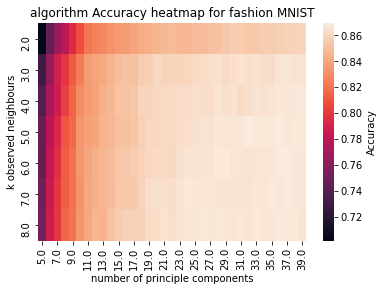

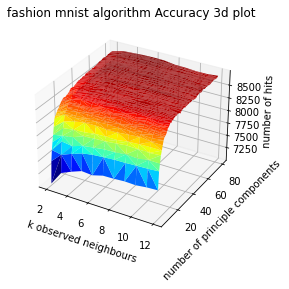

In [119]:
vis_knn.knn_heatmap("data/visualize_fashionmnist.npy",dropped_rows=([9, 10, 11, 12]),dropped_columns = ([40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]),figure_title="algorithm Accuracy heatmap for fashion MNIST")
vis_knn.knn_3dplot("data/visualize_fashionmnist.npy",figure_title="fashion mnist algorithm Accuracy 3d plot")

## Phone numbers
One possible application of handwritten digit recognition is digitalizing written information from documents like patient hospital forms, bank transfers or corona contact tracing forms. This can speed up bureaucracy because an algorithm can work much faster than an employee manually typing the information into a computer. Shown here is how the telephone number section of a form could work. The form needs to have a section that the computer can read and crop for the algorithm. Each box is a space in which a person can write one digit of their phone number.

Here is how a mock up form works with our algorithm:

The form is filled in with a digital pen or a mouse. Then the image is cropped. Each digit is converted to a 28*28 pixel greyscale image, which is then inverted and flattened. The resulting array can be fed to the algorithm.


Here is an example phone number. The program correctly identifies all the digits:

In [4]:
digits = form_filled_in("digits/Phone number form example.png")
phone_number = call_me_maybe(digits)
print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
012345678990

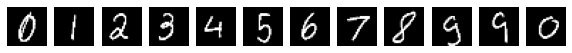

In [5]:
show_phone_numbers("digits/Phone number form example.png")

However, this is not always the case. Below is an example where the algorithm incorrectly predicts 11 out of the 12 digits:

In [6]:
digits = form_filled_in("digits/Phone number form example 2.png")
phone_number = call_me_maybe(digits)

print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

Your phone number is:
682558223226

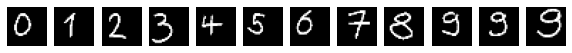

In [7]:
# The correct phone number:
show_phone_numbers("digits/Phone number form example 2.png")

The accuracy of the algorithm may differ on individual handwriting. The examples above are written by two different people. It seems to perform better or worse on different ways of writing individual numbers. Here you can see that depending on how the 4s are written they are predicted with higher or lower accuracy:

Your phone number is:
474764444444

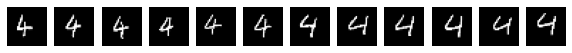

In [8]:
fours = "digits/Phone number form fours.png"
show_phone_numbers(fours)
digits = form_filled_in(fours)
phone_number = call_me_maybe(digits)

print("Your phone number is:")
for i in phone_number:
    i = int(i)
    print(i, end='')

To test how well the algorithm performs on “real” data it is necessary to collect more data. However the tendencies observed so far suggest the performance is lower than with the test data set. This means that perhaps 60000 training images are not enough for “real life” application.

Handwriting is unique to each person. Therefore the training data for knn might need to be even larger to account for more writing styles and number variations.
These numbers are based off of experimentation with our own handwriting and are therefore not representative.

Especially for phone numbers it is important to have a very low error rate because each incorrectly predicted image renders the entire phone number as unreachable. 

# Discussion

# References